# Kansas Data Preprocessing

This notebook explores datasets from Kansas and uses radial flow models to calculate pressure data from injection data. The earthquake catalog is well-formatted without many changes

## First Part
The first part of the notebook process earthquake catalog data in Kansas

In [92]:
from orion_light.seismic_catalog import SeismicCatalog
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import utm
import os

In [93]:
# Setting path for the seismic catalog data
seismic_csv='../datasets_Jul_7/kansas/kansasSeismicDetection.csv'

In [94]:
# Using pandas to load csv file
seismic_dataset=pd.read_csv(seismic_csv)

In [95]:
# Reordering the seismic catalog data into the format that we want and save it
seismic_reordered=pd.DataFrame({'epoch':seismic_dataset.epoch,
                                'latitude': seismic_dataset.latitude,
                                'longitude': seismic_dataset.longitude,
                                'depth': seismic_dataset.depth,
                                'easting': seismic_dataset.easting,
                                'northing': seismic_dataset.northing,
                                'magnitude': seismic_dataset.magnitude
                               })
seismic_reordered.to_csv('../Temporal_Datasets/kansas/seismic.csv',index=None)

In [96]:
# plt.hist(seismic_reordered['depth'])

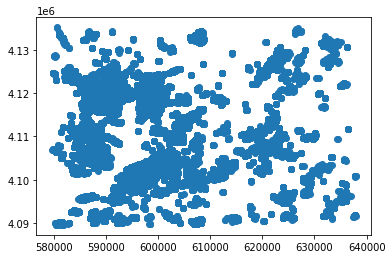

In [97]:
plt.scatter(seismic_reordered['easting'],seismic_reordered['northing'])

## Second Part
The second part of the notebook focuses on the processing of the injection datasets in Kansas
### Loading Injection Dataset

In [98]:
## Restart the work using the new datasets
# Loading Injection data
injection_csv='../datasets_Jul_7/Kansas/kansasInjection.csv'
injection_dataset=pd.read_csv(injection_csv,header=None,delimiter=' ')

In [101]:
# Transposing the dataset
injection_dataset_transpose = injection_dataset.transpose()
injection_dataset_transpose.head()

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,1.451635e+09,0.003736,0.0,0.003736,0.003171,0.003344,0.004723,0.002922,0.004140,0.001564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003162,0.003364
1,1.454314e+09,0.003381,0.0,0.003381,0.002659,0.003129,0.003950,0.002801,0.004018,0.001027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003003,0.003382
2,1.456819e+09,0.003715,0.0,0.003715,0.002627,0.003344,0.004685,0.002922,0.004140,0.001398,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003179,0.003825
3,1.459494e+09,0.003496,0.0,0.003496,0.002981,0.003237,0.004514,0.002861,0.004079,0.001378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003029,0.003676
4,1.462086e+09,0.003490,0.0,0.003490,0.002763,0.003344,0.004705,0.002861,0.004140,0.001508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003141,0.003469


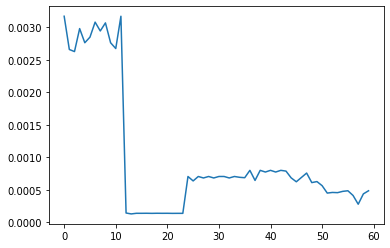

In [8]:
plt.plot(injection_dataset_transpose[4])

### Loading datasets with site information

In [9]:
# Loading site locations
site_csv = pd.read_csv('../datasets_Jul_7/kansas/kansas_well_apiLocation.txt',delimiter=' ')
site_csv.head()

,api,lat,lon
0,15077001230001,37.325,-98.248
1,15077010450002,37.124,-98.014
2,15077010820000,37.321,-98.256
3,15077100640001,37.362,-98.236
4,15077200120001,37.306,-98.214


In [10]:
from orion_light.seismic_catalog import SeismicCatalog

In [11]:
# Manually using calculate utm coordinates function
import utm
def calculate_utm_coordinates(latitude, longitude):
    """
    Convert catalog lat/lon coordinates to UTM
    """
    tmp = utm.from_latlon(latitude, longitude)
    easting = tmp[0]
    northing = tmp[1]
    utm_zone = str(tmp[2]) + tmp[3]
    return easting, northing, utm_zone

In [12]:
x = np.zeros(len(site_csv['lat']))
y = np.zeros(len(site_csv['lon']))
z = np.zeros(len(site_csv['lon'])) # all zeros
utm_list = [str(x) for x in site_csv['lat']]
for i in range(len(site_csv['lat'])):
    x[i],y[i],utm_list[i] = calculate_utm_coordinates(
        site_csv['lat'][i],site_csv['lon'][i])

In [13]:
locations_kansas = pd.DataFrame(x,columns=['x'])

In [14]:
locations_kansas['y'] = y
locations_kansas['z'] = z
locations_kansas['utms'] = utm_list

In [15]:
# storing locations in Kansas to an external file
locations_kansas.to_csv('../Temporal_Datasets/Kansas/locations.csv',index=None)

In [16]:
# Calculate for the first well
index = 0
epochs = injection_dataset_transpose[index]
x_loc = x[index]
y_loc = y[index]
z_loc = y[index]

In [17]:
# Getting epochs data
epochs = np.array(epochs)

In [18]:
# Add injection data to the dataframe locations_kansas as 'q'
(np.array(injection_dataset[1:])).shape
locations_kansas['q'] = np.array(injection_dataset[1:]).tolist()

In [19]:
# Show epochs data
injection_dataset_transpose[0].head()

0    1.451635e+09
1    1.454314e+09
2    1.456819e+09
3    1.459494e+09
4    1.462086e+09
Name: 0, dtype: float64

In [20]:
# saving wells in the format as used in well_tests.py
wells=[]
for index in range(len(locations_kansas.x)):
    wells.append({'x':locations_kansas.x[index],'y':locations_kansas.y[index],'z':locations_kansas.z[index],
                  't':epochs,'q':locations_kansas['q'][index]})

Text(0, 0.5, 'Northing (m)')

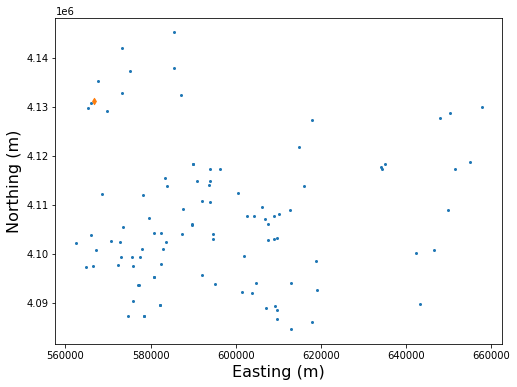

In [21]:
# wells location in Kansas
wells_idx = 0
fig = plt.figure(figsize=(8,6))
plt.scatter(x,y,marker='o',s=4)
plt.scatter(x[wells_idx],y[wells_idx],marker='d',s=20) # Labelling the first well in Kansas/
plt.xlabel('Easting (m)', fontsize=16)
plt.ylabel('Northing (m)', fontsize=16)

In [43]:
from orion_light import radial_flow, pressure_table
flow_model = radial_flow.RadialFlowModel()
flow_model.viscosity = 1.0
flow_model.permeability = 194.5 
flow_model.storativity = 0.0014 
flow_model.payzone_thickness = 500.0
flow_model.setup_model(wells) # Using only one well to test radial flow model
# setting up grid spacing

pressurization_range = 100 # determine the grid range 
# for the radial flow model 
number_of_points = 3 # determine the number of grid points in each direction
x_list = np.linspace(wells[wells_idx]['x']-pressurization_range,wells[wells_idx]['x']+pressurization_range,number_of_points)
y_list = np.linspace(wells[wells_idx]['y']-pressurization_range,wells[wells_idx]['y']+pressurization_range,number_of_points)
z_list = np.array([0.0,100.0])
t_list = np.linspace(epochs[0],epochs[-1],num=200)
G = np.meshgrid(x_list,y_list,z_list,t_list,indexing='ij')
# plot a 2D image to verify results, x, y as coordinates
# 2D slices or 3D surface plot
np.max(x)


# Using smoother to smooth the pressure
# x_list
# G = np.meshgrid(np.array(wells[0]['x']),np.array(wells[0]['y']),
#                     np.array(wells[0]['z']),t_list,indexing='ij')

657753.5414096521

In [44]:
x_list = np.linspace(np.min(x),np.max(x),20)
y_list = np.linspace(np.min(y),np.max(y),20)

In [45]:
G = np.meshgrid(x_list,y_list,z_list,t_list,indexing='ij')

In [46]:
p = flow_model(*G)

Text(0, 0.5, 'Pressure (kPa)')

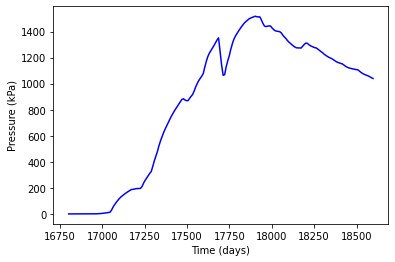

In [49]:
pressure_data = p[:,:,0,:]
# pressure_data_p_sum = np.sum(pressure_data,axis=2)
# pressure_data_p_sum.shape
t_scale = 24 * 60 * 60
plt.figure()
p_b = np.squeeze(p[4,4,0,:])*1e-3
plt.plot(np.squeeze(t_list) / t_scale, p_b,'b')
plt.xlabel('Time (days)')
plt.ylabel('Pressure (kPa)')


# Plotting the pressure data for one certain time
# np.squeeze(pressure_data[:,:,100])
# plt.imshow(pressure_data[:,:,100],aspect='auto',interpolation='nearest',origin='lower',
#            extent=[x_list[0], x_list[-1], y_list[0], y_list[-1]])

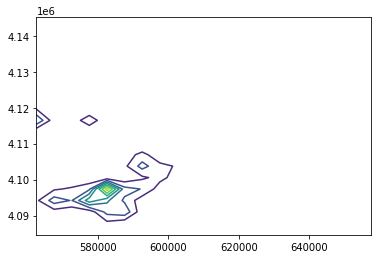

In [51]:
p_b = np.squeeze(p[:,:,0,100])
plt.contour(x_list,y_list,p_b)

In [75]:
p_b

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.62635566e-45,
       1.72778574e-41, 1.19909317e-38, 3.28131911e-36, 4.25965778e-34,
       3.01325485e-32, 1.29150283e-30, 3.64278729e-29, 7.21843135e-28,
       1.05900811e-26, 1.20032027e-25, 1.08846084e-24, 8.12864027e-24,
       5.12170235e-23, 2.77870266e-22, 1.32066921e-21, 5.58035963e-21,
       2.12291012e-20, 7.35081306e-20, 2.33872286e-19, 6.89349974e-19,
       1.89605548e-18, 4.89741700e-18, 1.19459266e-17, 2.76544777e-17,
       6.10273737e-17, 1.28889997e-16, 2.61460341e-16, 5.11103567e-16,
       9.65719852e-16, 1.76880801e-15, 3.14914580e-15, 5.46441628e-15,
       9.26522853e-15, 1.53890962e-14, 2.50982835e-14, 4.02811261e-14,
       6.37433852e-14, 9.96240273e-14, 1.53977820e-13, 2.35574324e-13,
       3.56968076e-13, 5.35896854e-13, 7.97062954e-13, 1.17434576e-12,
      

In [53]:
output_root = "../Temporal_Datasets/kansas/wells"
os.makedirs(output_root,exist_ok=True)

In [54]:
np.savetxt(os.path.join(output_root,'x.csv'),x_list,delimiter=',')
np.savetxt(os.path.join(output_root,'y.csv'),y_list,delimiter=',')
np.savetxt(os.path.join(output_root,'z.csv'),z_list,delimiter=',')
np.savetxt(os.path.join(output_root,'t.csv'),t_list,delimiter=',')


In [55]:
pressure_flat = np.reshape(p,(-1),order='F')
np.savetxt(os.path.join(output_root,'pressure.csv'),pressure_flat,delimiter=',')

In [56]:
# t_scale = 60.0 * 60.0 * 24.0
# p_b = np.squeeze(p[0,0,0,:])*1e-3
# plt.plot(np.squeeze(t_list) / t_scale, p_b, 'b')


In [57]:
pressure_table = pressure_table.PressureTableModel()
data = {k: np.loadtxt(os.path.join(output_root, '%s.csv' % (k))) for k in ['x', 'y', 'z', 't', 'pressure']}
pressure_table.load_array(**data)

In [58]:
t_scale = 60.0 * 60.0 * 24.0
x_list = np.linspace(np.min(x),np.max(x),20)
y_list = np.linspace(np.min(y),np.max(y),20)
z_list = np.array([0.0,100.0])
t_list = np.linspace(epochs[0],epochs[-1],num=200)
G = np.meshgrid(x_list,y_list,z_list,t_list,indexing='ij')
p = pressure_table.p(*G)

In [59]:
dpdt = pressure_table.dpdt(*G)

Text(0, 0.5, 'Pressurization Rate')

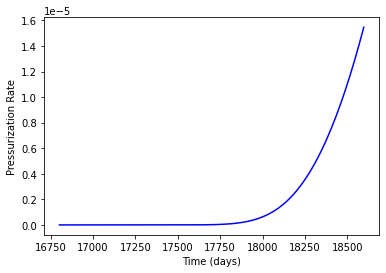

In [60]:
plt.figure()
p_b = np.squeeze(dpdt[0,0,0,:])
plt.plot(np.squeeze(t_list) / t_scale, p_b,'b')
plt.xlabel('Time (days)')
plt.ylabel('Pressurization Rate')

In [706]:
for i in range(0,20):
    for j in range(0,20):
        output_root = "../Temporal_Datasets/kansas/grid_points/grid_point_"+str(i)+'_'+str(j)
        os.makedirs(output_root)
        injection_cat = pd.DataFrame({
            'epoch': t_list,
#             'injection': injection_dataset
            'pressure': p[i,j,0,:],
            'dpdt': dpdt[i,j,0,:]
        })
        injection_cat.to_csv(output_root+str('/injection.csv'),index=None)

In [689]:
i = j = 0
injection_cat = pd.DataFrame({
            'epoch': t_list,
#             'injection': injection_dataset
            'pressure': p[i,j,0,:],
            'dpdt': dpdt[i,j,0,:]
        })

output_root = "../Temporal_Datasets/kansas/grid_point"+str(i)+str(j)

In [688]:
injection_cat.to_csv()

,epoch,pressure,dpdt
0,1.451635e+09,1.368400e-39,0.000000
1,1.452415e+09,1.368400e-39,0.000000
2,1.453195e+09,1.368400e-39,0.000000
3,1.453975e+09,1.368400e-39,0.000000
4,1.454754e+09,1.368400e-39,0.000000
...,...,...,...
195,1.603691e+09,2.620587e+02,0.000014
196,1.604470e+09,2.730790e+02,0.000014
197,1.605250e+09,2.844386e+02,0.000015
198,1.606030e+09,2.961437e+02,0.000015


In [692]:
injection_cat.to_csv(output_root,index=None)

In [79]:
x_list[4]
y_list[4]

4097372.53700248

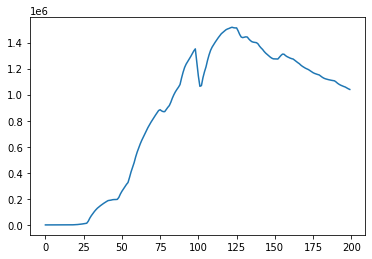

In [84]:
p_center = p[4,4,0,:]
plt.plot(p_center)

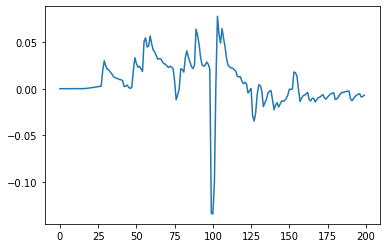

In [87]:
dpdt_center = dpdt[4,4,0,:]
plt.plot(dpdt_center)

In [88]:
injection = pd.DataFrame({
    'epoch': t_list,
    'pressure': p_center,
    'dpdt': dpdt_center
})

In [89]:
injection.to_csv('../Temporal_Datasets/kansas/injection.csv',index=None)